## Electronic Structure Calculations using QAOA

In the realm of quantum computing, Quantum Approximate Optimization Algorithm (QAOA) has gained significant attention due to its versatility in solving combinatorial optimization problems. While originally proposed for classical optimization, QAOA is now being explored for applications in electronic structure calculations, especially in scenarios where classical methods struggle with scalability and efficiency. The use of QAOA in quantum chemistry offers a unique approach to finding ground-state energies of molecular systems, bridging the gap between optimization and quantum simulation.

In electronic structure calculations, the primary objective is to solve the Schrödinger equation for a molecular system. Traditionally, methods like Hartree-Fock or Post-Hartree-Fock (MP2, CCSD) approximations have been employed to approximate wavefunctions and determine the energy states of electrons. QAOA, however, approaches the problem differently by framing it as an optimization task where the goal is to minimize the energy of the system. This is achieved through the construction of a cost Hamiltonian representing the energy of the system and a mixing Hamiltonian to explore different states. By optimizing the parameters in these Hamiltonians, QAOA aims to minimize the cost function, corresponding to the system’s ground-state energy.

The process begins with encoding the problem Hamiltonian, which represents the electronic interactions in the molecule. This Hamiltonian is mapped to qubits using methods like Jordan-Wigner or Bravyi-Kitaev transformations, translating the electronic problem into a quantum optimization problem. QAOA’s ansatz, composed of alternating layers of unitary operators based on the cost and mixing Hamiltonians, is then applied. By varying the parameters of these unitaries, QAOA gradually converges to a minimum energy solution, akin to how traditional variational algorithms operate.

One of the key advantages of using QAOA for electronic structure calculations is its inherent flexibility. It allows for tunable parameter optimization, which can provide more efficient exploration of the solution space compared to rigid classical methods. Additionally, QAOA can be implemented on near-term quantum devices, making it a practical candidate for quantum chemistry in the era of noisy intermediate-scale quantum (NISQ) computers. Unlike some other quantum algorithms that require fault-tolerant quantum computers, QAOA’s iterative and variational nature makes it resilient to certain noise levels.

The use of QAOA in electronic structure calculations is expected to evolve as quantum hardware matures. With better quantum processors and more sophisticated optimization techniques, QAOA could outperform classical methods in terms of speed and accuracy, especially for large and complex molecules. Research is already underway to refine the algorithm’s convergence properties and extend its application to broader classes of quantum chemistry problems, potentially revolutionizing fields like drug discovery, materials science, and catalysis.

While traditional methods in quantum chemistry are well-established, QAOA offers a promising alternative, leveraging quantum optimization for electronic structure calculations. Its adaptability and compatibility with current quantum hardware make it an exciting frontier for quantum chemists and engineers alike. As the algorithm and hardware improve, QAOA may unlock new possibilities for solving problems that were previously intractable by classical means.

#### Cost Hamiltonian in QAOA
The cost Hamiltonian \( H_C \) for a 2-qubit QAOA problem can be expressed as:

$$
H_C = -\alpha Z_0 Z_1 + \beta Z_0 + \gamma Z_1
$$

where:
- $Z_0 Z_1$ represents the interaction between qubits 0 and 1 (Pauli-Z operators),
- $\alpha$, $ \beta$, and $ \gamma$ are coefficients determining the strength of the interactions and individual qubit terms.

In [1]:
# Required imports
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector, partial_trace
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_city
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import QAOA
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Define the cost Hamiltonian: Z terms on 2 qubits (Diagonal in computational basis)
hamiltonian = SparsePauliOp.from_list([("ZZ", -1.0), ("ZI", 0.5), ("IZ", 0.5)])

In [3]:
# Number of layers for QAOA
p = 2


In [4]:
# QAOA ansatz without using PauliEvolution
def qaoa_ansatz(gamma, beta, num_qubits):
    qc = QuantumCircuit(num_qubits)
    
    # Initial layer of Hadamard gates
    qc.h(range(num_qubits))
    
    # Apply p layers of QAOA
    for i in range(p):
        # Cost Hamiltonian: ZZ interaction
        qc.rzz(2 * gamma[i], 0, 1)
        
        # Apply RX mixer Hamiltonian to all qubits
        qc.rx(2 * beta[i], range(num_qubits))
    
    return qc

In [5]:
# Number of qubits for the problem
num_qubits = 2

In [6]:
# Define optimizer and sampler
optimizer = COBYLA(maxiter=100)
sampler = Sampler()

In [7]:
# Define the QAOA instance
qaoa = QAOA(optimizer=optimizer, reps=p, sampler=sampler)

In [8]:
# Create a QAOA ansatz with random gamma and beta values
gamma = np.random.rand(p)
beta = np.random.rand(p)
qc_qaoa = qaoa_ansatz(gamma, beta, num_qubits)

In [9]:
# Add measurement to the circuit
qc_qaoa.measure_all()

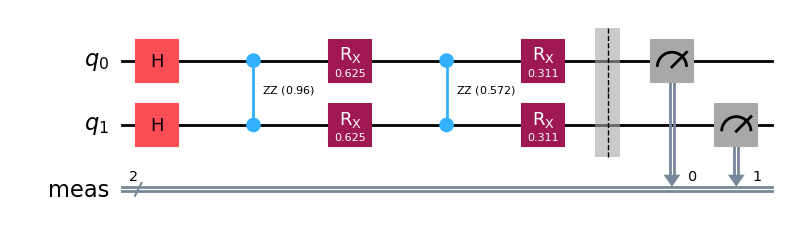

In [10]:
# Draw the circuit
qc_qaoa.draw('mpl')
plt.show()

In [11]:
# Use AerSimulator to simulate the circuit
simulator = AerSimulator(method="statevector")

In [12]:
# Run the circuit on the statevector simulator
job = simulator.run(qc_qaoa, shots=1024)
result = job.result()
counts = result.get_counts()

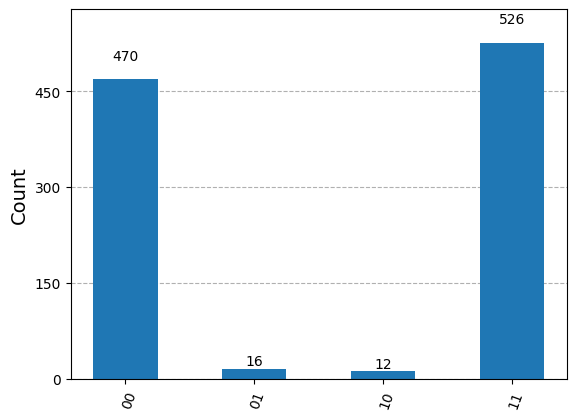

In [13]:
# Plot the final measurement histogram
plot_histogram(counts)
plt.show()

In [14]:
# Statevector visualization for Bloch sphere and state city
qc_qaoa.remove_final_measurements()  # Remove measurements for visualization
statevector = Statevector.from_instruction(qc_qaoa)

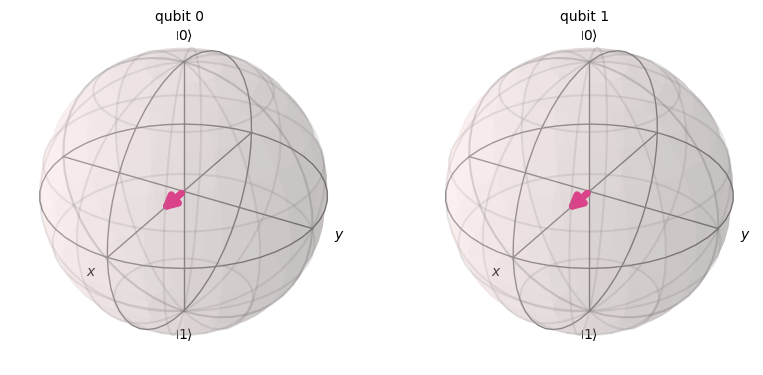

In [15]:
# Bloch sphere visualization for all qubits
plot_bloch_multivector(statevector)
plt.show()

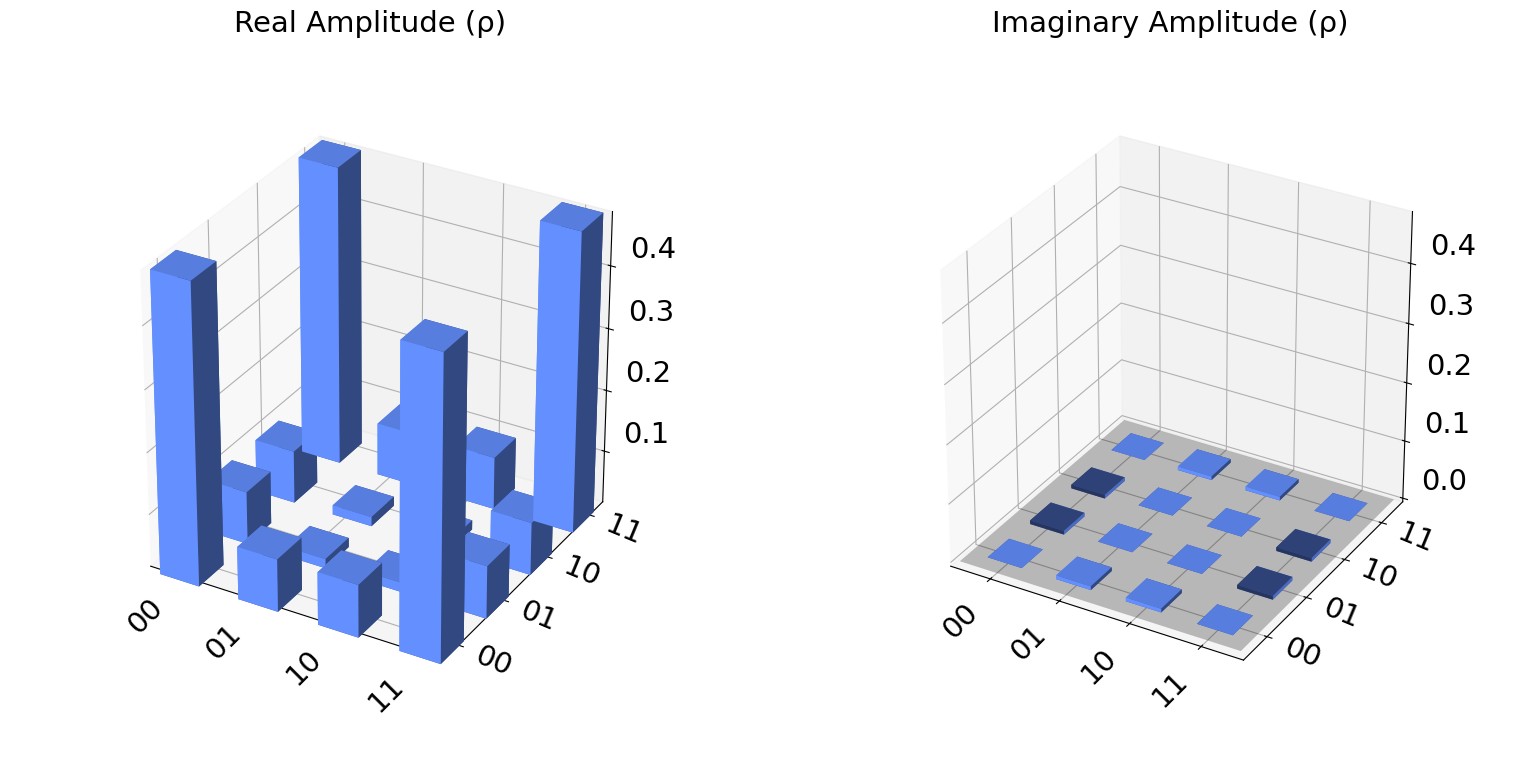

In [16]:
# State city plot of the full quantum state
plot_state_city(statevector)
plt.show()

In [17]:
# Partial trace to get the reduced density matrix of one qubit
reduced_density_matrix = partial_trace(statevector, [1])

In [18]:
# Print reduced density matrix
print("Reduced Density Matrix (after tracing out qubit 1):")
print(reduced_density_matrix)

Reduced Density Matrix (after tracing out qubit 1):
DensityMatrix([[0.5       +0.j, 0.17125257+0.j],
               [0.17125257+0.j, 0.5       +0.j]],
              dims=(2,))


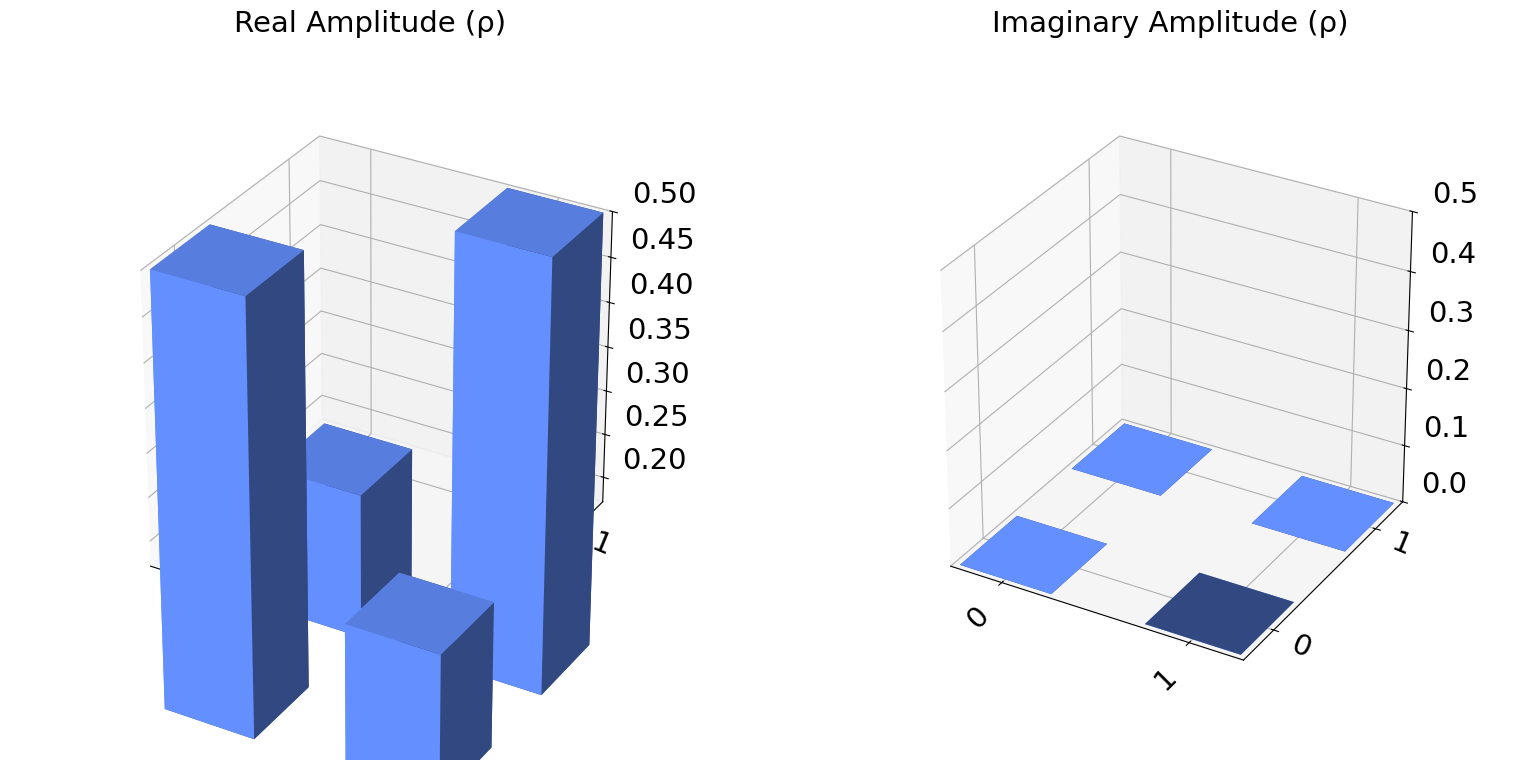

In [19]:
# State city plot of the partial quantum state
plot_state_city(reduced_density_matrix)
plt.show()

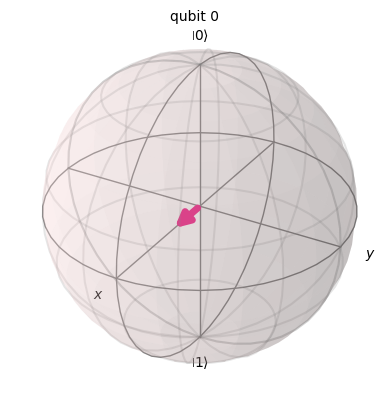

In [20]:
# Bloch sphere of the reduced qubit
plot_bloch_multivector(reduced_density_matrix)
plt.show()